In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/MyDrive/Computer_Vision/Files/'

Mounted at /content/drive
CameraCalibration1.jpg	ComputerVision1.pdf   Image.jpg  img4.png
CameraCalibration2.jpg	ComputerVision2.pdf   img1.jpg	 StereoVision.png
CameraCalibration3.jpg	EpipolarGeometry.png  img2.jpg
CameraCalibration4.jpg	Frame.png	      img3.png


# <i><b><font color='blue'> I - KeyPoints, RANSAC, drawMatches </font></b></i>

In [2]:
import cv2
import random

# Extract Features(KeyPoints) :
def extract_features( img1, img2) :
    # sift :
    sift = cv2.xfeatures2d.SIFT_create()

    # feature matching :
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    kp1, desc1 = sift.detectAndCompute(img1,None)
    kp2, desc2 = sift.detectAndCompute(img2,None)

    matches = bf.match(desc1,desc2)
    matches = sorted(matches, key = lambda x:x.distance)

    keypoints = [kp1,kp2]

    # find features and keypoints :
    correspondenceList = []

    for match in matches:
        (x1, y1) = keypoints[0][match.queryIdx].pt
        (x2, y2) = keypoints[1][match.trainIdx].pt
        correspondenceList.append([x1, y1, x2, y2])

    corrs = np.matrix(correspondenceList)
    return corrs , kp1, kp2, matches

# Homography Estimation :
def calculateHomography(correspondences):
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd( matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape( v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h


# Calculate the geometric distance between estimated points and original points :
def geometricDistance(correspondence, h):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

# Runs through ransac algorithm, creating homographies from random correspondences :
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        # find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        # call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:   # 5 pixels , depends on image size , ...
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers


# Draw Correspendances :
def drawMatches(img1, kp1, img2, kp2, matches, inliers = None):
    corresp = []
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1,:] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns, y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        inlier = False

        if inliers is not None:
            for i in inliers:
                if i.item(0) == x1 and i.item(1) == y1 and i.item(2) == x2 and i.item(3) == y2:
                    inlier = True

        ## Draw a small circle at both co-ordinates
        # cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        # cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points, draw inliers if we have them ( GBR)
        if inliers is not None and inlier:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 255, 0), 1)
            cv2.circle(out, (int(x1),int(y1)), 5, (255, 0, 0), 2) # added
            cv2.circle(out, (int(x2)+cols1,int(y2)), 5, (255, 0, 0), 2) # added
            corresp.append( [ ( int(x1), int(y1)), ( int(x2), int(y2) )] )

        # elif inliers is not None:  # R
            # cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 0, 255), 1)
        if inliers is None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1) 
            cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1) # added
            cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1) # added

    return out, corresp

# <i><b><font color='blue'> II - CORRESPONDANCES </font></b></i>

Number of correspendances : 14 
 


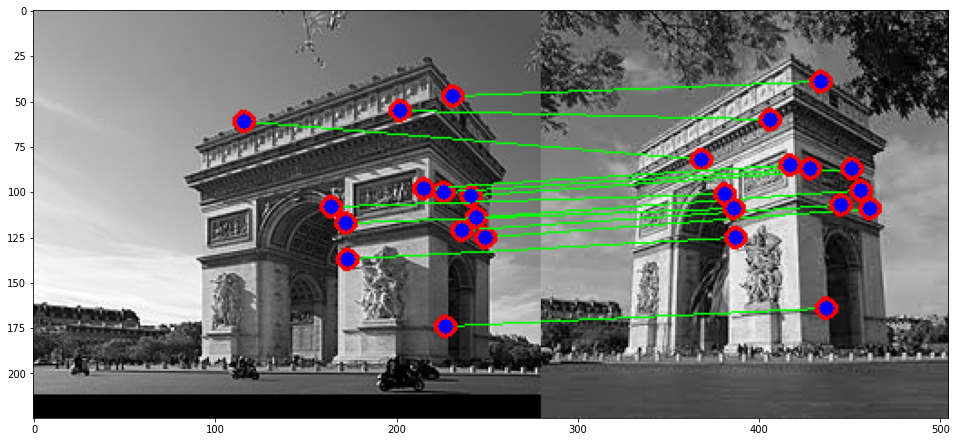

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# from im_matches import extract_features, ransac, drawMatches :
path1 = '/content/drive/MyDrive/Computer_Vision/Files/img1.jpg'
path2 = '/content/drive/MyDrive/Computer_Vision/Files/img2.jpg'

img1 = cv2.imread( path1)  
img2 = cv2.imread( path2) 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# img1 = cv2.resize(img1, (2000, 1500) )
# img2 = cv2.resize(img2, (2000, 1500) )

corrs, kp1, kp2, matches = extract_features( img1, img2) 

# run ransac algorithm :
threshold = 0.50
finalH, inliers = ransac(corrs, threshold)

# final goal : img_of_matches, correspandences = func( img1, img2)
matchImg, corresp = drawMatches( img1, kp1, img2, kp2, matches, inliers)

print( 'Number of correspendances : {} \n '.format(len( corresp)) )

out_img = matchImg
cols1 = img1.shape[1]


for pair in corresp:
    cv2.circle( out_img, pair[0], 4, ( 0, 0, 255), -1)
    cv2.circle( out_img, ( pair[1][0] + cols1, pair[1][1]), 4, ( 0, 0, 255), -1)


plt.figure( figsize=(20,7.5) )
plt.imshow( out_img)
plt.show()

# <i><b><font color='blue'> III - Epipolar Geometry of Stereo Vison: </font></b></i># 


<img src="https://drive.google.com/uc?export=view&id=1VIGioAb0BvbYdFxfbdPfH-si88o1OOPN" width="500"/>



<img src="https://drive.google.com/uc?export=view&id=1ca1MfEFeGUFwFQFY3DsOkl_RQp-9d_Nc" width="500"/>



Epipolar Constraint:


\begin{gather}
  \vec{n} = \vec{C_{L}C_{R}} \otimes \vec{p_{L}} = \vec{t} \otimes \vec{p_{L}}  
\end{gather}

$\vec{n}$ is a normal vector to the epipolar plane, therefore:
\begin{gather}
   \vec{p_{L}} * \vec{n} = \vec{p_{L}} * ( \vec{t} \otimes \vec{p_{L}} ) = 0
\end{gather}

The cross product can be written as:
\begin{gather}
  \vec{p_{L}} * ( \vec{t} \otimes \vec{p_{L}} ) =
  p_{L} *
  \begin{bmatrix}
    0 & -t_{z} & t_{y}\\
    t_{z} & 0 & -t_{x}\\
    -t_{y} & t_{x} & 0\\
  \end{bmatrix}
  * p_{L} = 0
\end{gather}

We Know that:
\begin{gather}
  \vec{p_{L}} = R * \vec{p_{R}} + \vec{t}  
\end{gather}

Therefore:
\begin{gather}
  p_{L} *
  \begin{bmatrix}
    0 & -t_{z} & t_{y}\\
    t_{z} & 0 & -t_{x}\\
    -t_{y} & t_{x} & 0\\
  \end{bmatrix}
  *
  \begin{bmatrix}
    r_{11} & r_{12} & r_{13}\\
    r_{21} & r_{22} & r_{23}\\
    r_{31} & r_{32} & r_{33}\\
  \end{bmatrix}
  * p_{R} = 0
\end{gather}

Essential Matrix:
\begin{gather}
  p_{L}^{T} * E * p_{R} = 0
\end{gather}

\begin{gather}
  \begin{bmatrix}
    x_{L} & y_{L} & z_{L}\\
  \end{bmatrix}
  * E *
  \begin{bmatrix}
    x_{R}\\
    y_{R}\\
    z_{R}\\
  \end{bmatrix}
  = 0
\end{gather}

\begin{gather}
  E = T_{X} * R =
  \begin{bmatrix}
    0 & -t_{z} & t_{y}\\
    t_{z} & 0 & -t_{x}\\
    -t_{y} & t_{x} & 0\\
  \end{bmatrix}
  *
  \begin{bmatrix}
    r_{11} & r_{12} & r_{13}\\
    r_{21} & r_{22} & r_{23}\\
    r_{31} & r_{32} & r_{33}\\
  \end{bmatrix}
\end{gather}

$T_{x}$ is skew-symmetric ($a_{ij} = -a_{ji}$), and $R$ is orthonormal, which means E can be decoupled using SVD decomposition to calculate $R$ and $t$.

We don't have the $p_{L}$ and $p_{R}$ (in 3D), but we know corresponding points in the image coordinates:

$ 
  z_{L} * 
  \begin{bmatrix}
    u_{L} \\
    v_{L} \\
    1 \\
  \end{bmatrix}
  =
  K_{L} *
  \begin{bmatrix}
    x_{L} \\
    y_{L} \\
    z_{L} \\
  \end{bmatrix}
$ and $  
  z_{R} * 
  \begin{bmatrix}
    u_{R} \\
    v_{R} \\
    1 \\
  \end{bmatrix}
  =
  K_{R} *
  \begin{bmatrix}
    x_{R} \\
    y_{R} \\
    z_{R} \\
  \end{bmatrix}
$

Therefore:
\begin{gather}
  \begin{bmatrix}
    u_{L} & v_{L} & 1\\
  \end{bmatrix}
   * z_{L} * {K_{L}^{-1}}^{T} * E *  K_{R}^{-1} * z_{R} *
  \begin{bmatrix}
    u_{R}\\
    v_{R}\\
    1\\
  \end{bmatrix}
  = 0
\end{gather}

$z_{L} = 0$ and $z_{R} = 0$ otherwise $z_{L} = C_{L}$ and $z_{R} = C_{R}$, which is impossible:
\begin{gather}
  \begin{bmatrix}
    u_{L} & v_{L} & 1\\
  \end{bmatrix}
   * {K_{L}^{-1}}^{T} * E *  K_{R}^{-1} * 
  \begin{bmatrix}
    u_{R}\\
    v_{R}\\
    1\\
  \end{bmatrix}
  =
  \begin{bmatrix}
    u_{L} & v_{L} & 1\\
  \end{bmatrix}
   * F *
  \begin{bmatrix}
    u_{R}\\
    v_{R}\\
    1\\
  \end{bmatrix}
  = 0
\end{gather}



$ E = K_{L}^{T} * F * K_{R}$  and  $F = {K_{L}^{-1}}^{T} * E * K_{R}^{-1}$

In [4]:
import numpy as np
from math import sqrt
from random import randint, shuffle


# Matches [ uL, vL, uR, vR]
matches = corresp
shuffle(matches)

uL, vL, uR, vR = [], [], [], []
for (u1, v1), (u2, v2) in matches:
    uL.append( u1 )
    vL.append( v1 )
    uR.append( u2 )
    vR.append( v2 )

# Calculate A:
N = 8
A = np.zeros( (N, 9) )
for n in range(N):
    A[n] = np.array([ uL[n] * uR[n], uL[n] * vR[n], uL[n], vL[n] * uR[n], vL[n] * vR[n], vL[n], uR[n], vR[n], 1])

# <i><b><font color='blue'> IV - Solve Equations: </font></b></i># 

\begin{gather}
  \begin{bmatrix}
    u_{L}^{(i)} & v_{L}^{(i)} & 1\\
  \end{bmatrix}
  *
  \begin{bmatrix}
    f_{11} & f_{12} & f_{13}\\
    f_{21} & f_{22} & f_{23}\\
    f_{31} & f_{32} & f_{33}\\
  \end{bmatrix}
  *
  \begin{bmatrix}
    u_{R}^{(i)}\\
    v_{R}^{(i)}\\
    1\\
  \end{bmatrix}
  = 0
\end{gather}


Which can be written as:
\begin{gather}
  A_{i} * f =
  \begin{bmatrix}
    u_{L}^{(i)} * u_{R}^{(i)}&
    u_{L}^{(i)} * v_{R}^{(i)}&
    u_{L}^{(i)}&
    v_{L}^{(i)} * u_{R}^{(i)}&
    v_{L}^{(i)} * v_{R}^{(i)}&
    v_{L}^{(i)}&
    u_{R}^{(i)}&
    v_{R}^{(i)}&
    1&
  \end{bmatrix}
  *
  \begin{bmatrix}
    f_{11}\\
    f_{12}\\
    f_{13}\\
    f_{21}\\
    f_{22}\\
    f_{23}\\
    f_{31}\\
    f_{32}\\
    f_{33}\\
  \end{bmatrix}
  = \vec{0}
\end{gather}

If $f$ is a solution then $k*f$ ($k \neq 0$) is also a solution, which means f is defined only up to a scale, we set the fundamental matrix up to some arbitrary scale: $ ||f|| = 1 $



\begin{gather}
    \underset{p}{min} || A*f ||^{2}
\end{gather}

\begin{gather}
    || f || = 1
\end{gather}

Loss function:

\begin{gather}
    L(f, \lambda) = f^{T} * A^{T} * A * f - \lambda * ( f^{T} * f -1 )
\end{gather}

*Equavilent to: (Derivative)*

\begin{gather}
    A^{T} * A * f = \lambda * f
\end{gather}

The solution is the eigenvector of A.T @ A associated with the smallest eigenvalue.

We need 8 points to compute f, since f has 8 independant unkown parameters. 

Constraint: to enforce rank 2 of F, we can decompose it as
SVD, put σ3 = 0 and recompose


To get even better results, we can use RANSAC:

1/- For many times:

      - pick 8 points

      - compute a solution for F

      - compute number of inliers

2/- Pick the solution with the largest number of inliers


( $p_{L} * F * p_{R}$ < threshold )

In [5]:
# P is only defined up to a scale => ||p|| = 1 
# find eigenvector with smallest eigenvalue: A.T * A * p = lambda * p 
w, v = np.linalg.eig( A.T @ A ) 
idx_min = np.argmin( w)
f = v.T[idx_min] 

F = f.reshape(3, 3)

# Verification:
loss = abs( np.array( [ uL[n], vL[n], 1 ] ) @ F @ np.array( [ uR[n], vR[n], 1 ] ))
print( loss )

1.623812195816754e-11


# <i><b><font color='blue'> V - Epipolar Line: </font></b></i>#

Epipolar line equation: $ \vec{e_{R}p_{R}} $

<img src="https://drive.google.com/uc?export=view&id=1ca1MfEFeGUFwFQFY3DsOkl_RQp-9d_Nc" width="500"/>


Let assume $\vec{p_{L}} = [ u_{L}, v_{L}, 1 ] $ is known, 
Then the equation of the epipolar line $ \vec{e_{R}p_{R}} $ is defined as follow:


\begin{gather}
    ( f_{11} * u_{L} + f_{12} * v_{L} + f_{13}) * u_{R} + ( f_{21} * u_{L} + f_{22} * v_{L} + f_{23}) * v_{R} + ( f_{31} * u_{L} + f_{32} * v_{L} + f_{33}) = 0
\end{gather}


\begin{gather}
    a * u_{R} + b * v_{R} + c = 0
\end{gather}


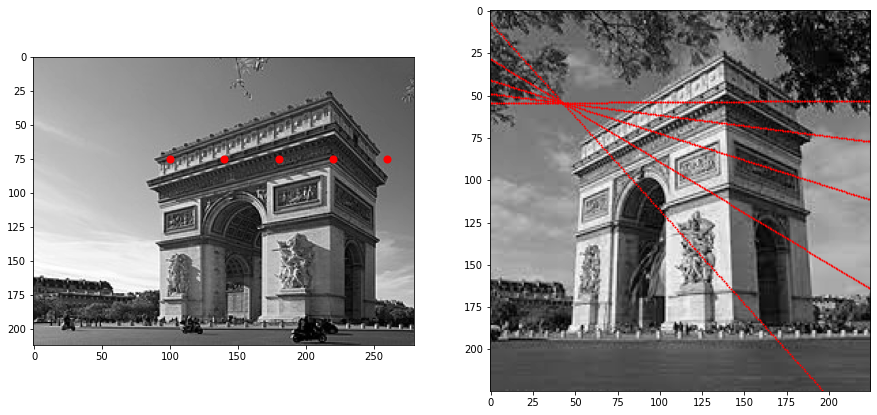

In [6]:
path1 = '/content/drive/MyDrive/Computer_Vision/Files/img1.jpg'
path2 = '/content/drive/MyDrive/Computer_Vision/Files/img2.jpg'

img1 = cv2.imread( path1)  
img2 = cv2.imread( path2) 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)



# Epipolar line equation: 
H, W = img2.shape
U, V = [], []

uuL, vvL = [ 100, 140, 180, 220, 260], [75, 75, 75, 75, 75]
for ul, vl in zip(uuL, vvL):
    a = F[0,0] * ul + F[1,0] * vl + F[2,0] 
    b = F[0,1] * ul + F[1,1] * vl + F[2,1] 
    c = F[0,2] * ul + F[1,2] * vl + F[2,2]

    for u in range(W):
        v = - ( c + a * u)/b 
        if ( 0 < v < H-1 ): 
            U.append( u )
            V.append( v )

plt.figure( figsize=(15,10) )
plt.subplot( 1,2,1 )
plt.imshow( img1, cmap='gray')
plt.scatter( uuL, vvL, c='r', s=50 )
plt.subplot( 1,2,2 )
plt.imshow( img2, cmap='gray')
plt.scatter( U, V, c='r', s=1 )
plt.show()

# <i><b><font color='blue'> VI - SVD Decomposition: </font></b></i>#

Example:
\begin{gather}
    F_{4*3} = U_{4*4} * S_{4*3} * V_{3*3} =
    \begin{bmatrix}
      |  & |  & |  & | \\
      u1 & u2 & u3 & u4\\
      |  & |  & |  & | \\
    \end{bmatrix}
    *
    \begin{bmatrix}
      1 & 0 & 0\\
      0 & 1 & 0\\
      0 & 0 & 1\\
      0 & 0 & 0\\
    \end{bmatrix}
    *
    \begin{bmatrix}
      -- & v1 & --\\
      -- & v2 & --\\
      -- & v3 & --\\
    \end{bmatrix}
\end{gather}

Let's assume: (for decomposition, and because we don't have enough information)
\begin{gather}
    K_{L} = K_{R} = K =
    \begin{bmatrix}
        2759.48 & 0 & 1520.69\\ 
        0 & 2764.16 & 1006.81\\ 
        0 & 0 & 1\\ 
    \end{bmatrix}
\end{gather}

Then:
\begin{gather}
    E =  K^{T} * F * K = U * S* V
\end{gather}



In [ ]:
K = np.array( [2759.48, 0, 1520.69, 
              0, 2764.16, 1006.81, 
              0, 0, 1] ).reshape( 3, 3 )

E = K.T.dot(F).dot(K)

U, S, V = np.linalg.svd( E )

W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)

R1 = U @ W @ V 
R2 = U @ W.T @ V 
T = U @ np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]).reshape(3, 3) @ U.T

E1 = T @ R1
E2 = T @ R2

print( E1/E1[2,2], '\n\n', E2/E2[2,2], '\n\n', E/E[2,2] )

[[  2.86348817 -27.48209251  -7.18718968]
 [ 26.59409957   3.32389598  15.2888937 ]
 [  9.93966157 -13.6155786    1.        ]] 

 [[  2.86348817 -27.48209251  -7.18718968]
 [ 26.59409957   3.32389598  15.2888937 ]
 [  9.93966157 -13.6155786    1.        ]] 

 [[ -1.05623143 -10.54369437  -3.91083504]
 [ 16.10210188   3.59827152   9.76016483]
 [  4.52916735  -4.48899784   1.        ]]


# <i><b><font color='blue'> VII - Computing Depth: </font></b></i>#

$
    \begin{bmatrix}
      u_{L} \\
      v_{L} \\
      1 \\
    \end{bmatrix}
    =
    \begin{bmatrix}
      f_{x}^{L} & 0 & h/2 & 0\\
      0 & f_{y}^{L} & w/2 & 0\\
      0 & 0 & 1 & 0\\
    \end{bmatrix}
    *
    \begin{bmatrix}
      x_{L}\\
      y_{L}\\
      z_{L}\\
      1\\
    \end{bmatrix}
$ and $
    \begin{bmatrix}
      u_{R} \\
      v_{R} \\
      1 \\
    \end{bmatrix}
    =
    \begin{bmatrix}
      f_{x}^{R} & 0 & h/2 & 0\\
      0 & f_{y}^{R} & w/2 & 0\\
      0 & 0 & 1 & 0\\
    \end{bmatrix}
    *
    \begin{bmatrix}
      x_{R}\\
      y_{R}\\
      z_{R}\\
      1\\
    \end{bmatrix}
$


\begin{gather}
    \begin{bmatrix}
      x_{L}\\
      y_{L}\\
      z_{L}\\
      1\\
    \end{bmatrix}
    =
    \begin{bmatrix}
      r_{11} & r_{12} & r_{13} & t_{x}\\
      r_{21} & r_{22} & r_{23} & t_{x}\\
      r_{31} & r_{32} & r_{33} & t_{x}\\
      0 & 0 & 1 & 0\\
    \end{bmatrix}
    *
    \begin{bmatrix}
      x_{R}\\
      y_{R}\\
      z_{R}\\
      1\\
    \end{bmatrix}
\end{gather}



\begin{gather}
    \begin{bmatrix}
      u_{L} \\
      v_{L} \\
      1 \\
    \end{bmatrix}
    =
    K_{L} *
    \begin{bmatrix}
      R_{3*3} & t_{3*1}\\
      0_{1*3} & 1\\
    \end{bmatrix}
    *
    \begin{bmatrix}
      x_{R}\\
      y_{R}\\
      z_{R}\\
      1\\
    \end{bmatrix}
\end{gather}



\begin{gather}
    \tilde{u}_{R} = K_{R} * \tilde{X}_{R} = M * \tilde{X}_{R}  
\end{gather}

\begin{gather}
    \tilde{u}_{L} = K_{L} * [R|t] * \tilde{X}_{R} = P * \tilde{X}_{R}
\end{gather}

Wich can be written as:

\begin{gather}
    \begin{bmatrix}
      u_{R}*m_{31} - m_{11} & u_{R}*m_{32} - m_{12} & u_{R}*m_{33} - m_{13}\\
      v_{R}*m_{31} - m_{21} & v_{R}*m_{32} - m_{22} & v_{R}*m_{33} - m_{23}\\
      u_{L}*p_{31} - p_{11} & u_{L}*p_{32} - p_{11} & u_{L}*p_{33} - p_{13}\\
      v_{L}*p_{31} - p_{21} & v_{L}*p_{32} - p_{22} & v_{L}*p_{33} - p_{23}\\
    \end{bmatrix}
    *
    \begin{bmatrix}
      x_{R}\\
      y_{R}\\
      z_{R}\\
    \end{bmatrix}
    =
    \begin{bmatrix}
      m_{14}-m_{34}\\
      m_{24}-m_{34}\\
      p_{14}-p_{34}\\
      p_{24}-p_{34}\\
    \end{bmatrix}
\end{gather}

\begin{gather}
    A_{4*3} * x_{r} = b_{4*1}
\end{gather}

To reconstruct the depth map:
\begin{gather}
    x_{r} = (A^{T} * A)^{-1} * A^{T} * b
\end{gather}